# Code to Adjust Offensive, Defensive and Net Ratings for Strength of Schedule

In [15]:
from sklearn.linear_model import RidgeCV
import os, sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from nbafuns import *

# from sklearn.pipeline import make_pipeline
# model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

teams_dict, teams_list = get_teams(league="NBA")
box_DIR = "../data/box/"
img_DIR_T = "../data/images/teams/"

In [3]:
def get_ratings(season=2024,ngames=0):
    cols = [
        "gameId",
        "teamName",
        "teamId",
        "offensiveRating",
        "defensiveRating",
        "netRating",
        "possessions",
    ]
    df = pd.read_parquet(box_DIR + f"NBA_Box_T_Adv_{season}.parquet", columns=cols)
    cols = ["gameId", "team", "tId", "ORtg", "DRtg", "NRtg", "poss"]
    df.columns = cols
    df1 = df.groupby("gameId")
    df1_1 = df1.nth(0)
    df1_2 = df1.nth(1)
    df1_1.columns = ["gameId"] + [s + "1" for s in df1_1.columns if s != "gameId"]
    df1_2.columns = ["gameId"] + [s + "2" for s in df1_2.columns if s != "gameId"]
    df1_3 = pd.merge(df1_1, df1_2, on="gameId")
    df1_4 = df1.nth(1)
    df1_5 = df1.nth(0)
    df1_4.columns = ["gameId"] + [s + "1" for s in df1_4.columns if s != "gameId"]
    df1_5.columns = ["gameId"] + [s + "2" for s in df1_5.columns if s != "gameId"]
    df1_6 = pd.merge(df1_4, df1_5, on="gameId")
    df2 = pd.concat([df1_3, df1_6]).sort_values(by="gameId").reset_index(drop=True)
    data1 = df2.copy()
    stats = leaguegamelog.LeagueGameLog(
        player_or_team_abbreviation="T",
        season=season,
        season_type_all_star="Regular Season",
    )
    df10 = stats.get_data_frames()[0]
    if ngames != 0:
        df10g = df10.groupby("TEAM_NAME")
        df10 = df10g.nth(np.arange(-ngames,0,1)).reset_index(drop=True)
    df10["HOME"] = ~df10["MATCHUP"].str.contains("@")
    df10["tId1"] = df10["TEAM_ID"]
    df10["gameId"] = df10["GAME_ID"]
    df11 = (
        df10[["gameId", "tId1", "HOME"]].sort_values(by="gameId").reset_index(drop=True)
    )
    df11[["gameId", "tId1"]] = df11[["gameId", "tId1"]].astype(int)
    data = pd.merge(data1, df11)
    return data

In [4]:
def process_results(data, results_adj):
    data["pts1"] = data["ORtg1"] * data["poss1"]
    data["pts2"] = data["DRtg1"] * data["poss1"]
    off_prior = data.groupby(["tId1"])[["poss1", "pts1"]].agg("sum").reset_index()
    def_prior = data.groupby(["tId1"])[["poss1", "pts2"]].agg("sum").reset_index()
    off_prior["OFF"] = off_prior["pts1"] / off_prior["poss1"]
    off_prior = off_prior[["tId1", "OFF"]]
    def_prior["DEF"] = def_prior["pts2"] / def_prior["poss1"]
    def_prior = def_prior[["tId1", "DEF"]]
    results_net = pd.merge(off_prior, def_prior, on=["tId1"])
    results_net["NET"] = results_net["OFF"] - results_net["DEF"]
    results_net.rename(columns={"tId1": "tId"}, inplace=True)
    results_net = results_net.astype(float).round(2)
    results_net["tId"] = results_net["tId"].astype(int)
    ortg_mean = data["pts1"].sum() / data["poss1"].sum()
    drtg_mean = data["pts2"].sum() / data["poss1"].sum()
    results_adj["tId"] = results_adj["tId"].astype(int)
    results_comb = pd.merge(results_net, results_adj, on=["tId"])
    results_comb["aOFF"] = results_comb["aOFF"]
    results_comb["aDEF"] = results_comb["aDEF"]
    results_comb["oSOS"] = results_comb["aOFF"] - results_comb["OFF"]
    results_comb["dSOS"] = results_comb["DEF"] - results_comb["aDEF"]
    results_comb["SOS"] = results_comb["oSOS"] + results_comb["dSOS"]
    results_comb.iloc[:, 1:] = results_comb.iloc[:, 1:].round(1)
    results = results_comb[
        ["Team", "OFF", "oSOS", "aOFF", "DEF", "dSOS", "aDEF", "NET", "SOS", "aNET"]
    ]
    # results = results_comb[["Team","OFF","DEF","NET","aOFF","aDEF","aNET"]]
    results = results.sort_values(by="aNET", ascending=0).reset_index(drop=True)
    return results, ortg_mean, drtg_mean

In [5]:
def map_teams(row_in, teams, scale):
    t1 = row_in[0]
    t2 = row_in[1]

    rowOut = np.zeros([len(teams) * 2])
    rowOut[teams.index(t1)] = scale
    rowOut[teams.index(t2) + len(teams)] = scale

    return rowOut


def convert_to_matricies(possessions, name, teams, scale=1):
    # extract only the columns we need
    # Convert the columns of player ids into a numpy matrix
    stints_x_base = possessions[["tId1", "tId2"]].to_numpy()
    # Apply our mapping function to the numpy matrix
    stint_X_rows = np.apply_along_axis(map_teams, 1, stints_x_base, teams, scale=scale)
    # Convert the column of target values into a numpy matrix
    stint_Y_rows = possessions[name].to_numpy()

    # return matricies and possessions series
    return stint_X_rows, stint_Y_rows


# Convert lambda value to alpha needed for ridge CV


def lambda_to_alpha(lambda_value, samples):
    return (lambda_value * samples) / 2.0


# Convert RidgeCV alpha back into a lambda value


def alpha_to_lambda(alpha_value, samples):
    return (alpha_value * 2.0) / samples


def calculate_netrtg(train_x, train_y, lambdas, teams_list):
    alphas = [lambda_to_alpha(l, train_x.shape[0]) for l in lambdas]
    # create a 5 fold CV ridgeCV model. Our target data is not centered at 0, so we want to fit to an intercept.
    clf = RidgeCV(alphas=alphas, cv=5, fit_intercept=True)

    # fit our training data
    model = clf.fit(
        train_x,
        train_y,
    )

    # convert our list of players into a mx1 matrix
    team_arr = np.transpose(np.array(teams_list).reshape(1, len(teams_list)))

    # extract our coefficients into the offensive and defensive parts
    coef_offensive_array = model.coef_[0 : len(teams_list)][np.newaxis].T
    coef_defensive_array = model.coef_[len(teams_list) : 2 * len(teams_list)][
        np.newaxis
    ].T
    # concatenate the offensive and defensive values with the playey ids into a mx3 matrix
    team_id_with_coef = np.concatenate(
        [team_arr, coef_offensive_array, coef_defensive_array], axis=1
    )
    # build a dataframe from our matrix
    teams_coef = pd.DataFrame(team_id_with_coef)
    intercept = model.intercept_
    teams_coef.columns = ["tId", "aOFF", "aDEF"]
    teams_coef["aNET"] = teams_coef["aOFF"] - teams_coef["aDEF"]
    teams_coef["aOFF"] = teams_coef["aOFF"] + intercept
    teams_coef["aDEF"] = teams_coef["aDEF"] + intercept
    teams_coef["Team"] = teams_coef["tId"].map(teams_dict)
    results = teams_coef[["tId", "Team", "aOFF", "aDEF", "aNET"]]
    results = results.sort_values(by=["aNET"], ascending=False).reset_index(drop=True)
    return results, model, intercept

In [59]:
datar = get_ratings(2024,ngames=10)

In [64]:
train_x, train_y = convert_to_matricies(datar, "ORtg1", teams_list, scale=1 / 2)
n = 1.5
# n = 1.5/2
lambdas_net = [0.01 * n, 0.05 * n, 0.1 * n]
# lambdas_net = [10/3]
results_adj, model, intercept = calculate_netrtg(
    train_x, train_y, lambdas_net, teams_list
)
results, ortg_mean, drtg_mean = process_results(datar, results_adj)
results.index = results.index +1
print(intercept)
# results.head(5)
# results.sort_values(by="aOFF",ascending=0)
# results.sort_values(by="aDEF",ascending=1)
# results.sort_values("aNET",ascending=False)

111.97423161041851


In [65]:
results["OFF_R"] = results["OFF"].rank(ascending=False  ,method="first").astype(int)
results["DEF_R"] = results["DEF"].rank(ascending=True   ,method="first").astype(int)
results["NET_R"] = results["NET"].rank(ascending=False  ,method="first").astype(int)
results["aOFF_R"] = results["aOFF"].rank(ascending=False,method="first").astype(int)
results["aDEF_R"] = results["aDEF"].rank(ascending=True ,method="first").astype(int)
results["aNET_R"] = results["aNET"].rank(ascending=False,method="first").astype(int)

In [66]:
results

,Team,OFF,oSOS,aOFF,DEF,dSOS,aDEF,NET,SOS,aNET,OFF_R,DEF_R,NET_R,aOFF_R,aDEF_R,aNET_R
1,Cleveland Cavaliers,118.0,0.3,118.2,105.0,-0.5,105.4,13.0,-0.2,12.8,3,4,1,3,3,1
2,Memphis Grizzlies,118.4,0.2,118.6,105.8,-0.1,105.9,12.6,0.1,12.7,2,5,3,2,4,2
3,Oklahoma City Thunder,115.6,-0.3,115.3,102.7,-0.3,103.1,12.9,-0.6,12.2,8,2,2,9,2,3
4,Boston Celtics,117.2,0.3,117.5,108.4,1.2,107.1,8.8,1.5,10.3,6,6,5,5,5,4
5,New York Knicks,115.5,-0.2,115.3,104.3,-3.7,108.0,11.2,-3.9,7.3,10,3,4,10,7,5
6,Dallas Mavericks,119.6,0.4,120.0,113.2,0.1,113.1,6.3,0.5,6.9,1,17,6,1,19,6
7,Denver Nuggets,117.7,0.5,118.2,115.6,2.8,112.8,2.1,3.3,5.4,4,22,11,4,18,7
8,Sacramento Kings,117.3,-0.5,116.8,111.7,-0.3,112.0,5.6,-0.8,4.8,5,14,7,6,14,8
9,Minnesota Timberwolves,105.5,0.4,105.9,101.3,-0.2,101.5,4.2,0.2,4.4,28,1,8,28,1,9
10,LA Clippers,112.1,-0.1,112.1,108.4,0.4,108.0,3.7,0.3,4.1,15,7,10,13,8,10


In [57]:
df_teams = pd.read_csv("../data/NBA_teams_colors_logos.csv")
df_teams = df_teams.rename(columns={"nameTeam": "Team"})
data = pd.merge(results, df_teams)
data["image"] = img_DIR_T + data["Team"] + ".png"
data["label"] ="#"+ data["aNET_R"].astype(str)+ " Net"
today = datetime.today().strftime("%B %d, %Y")

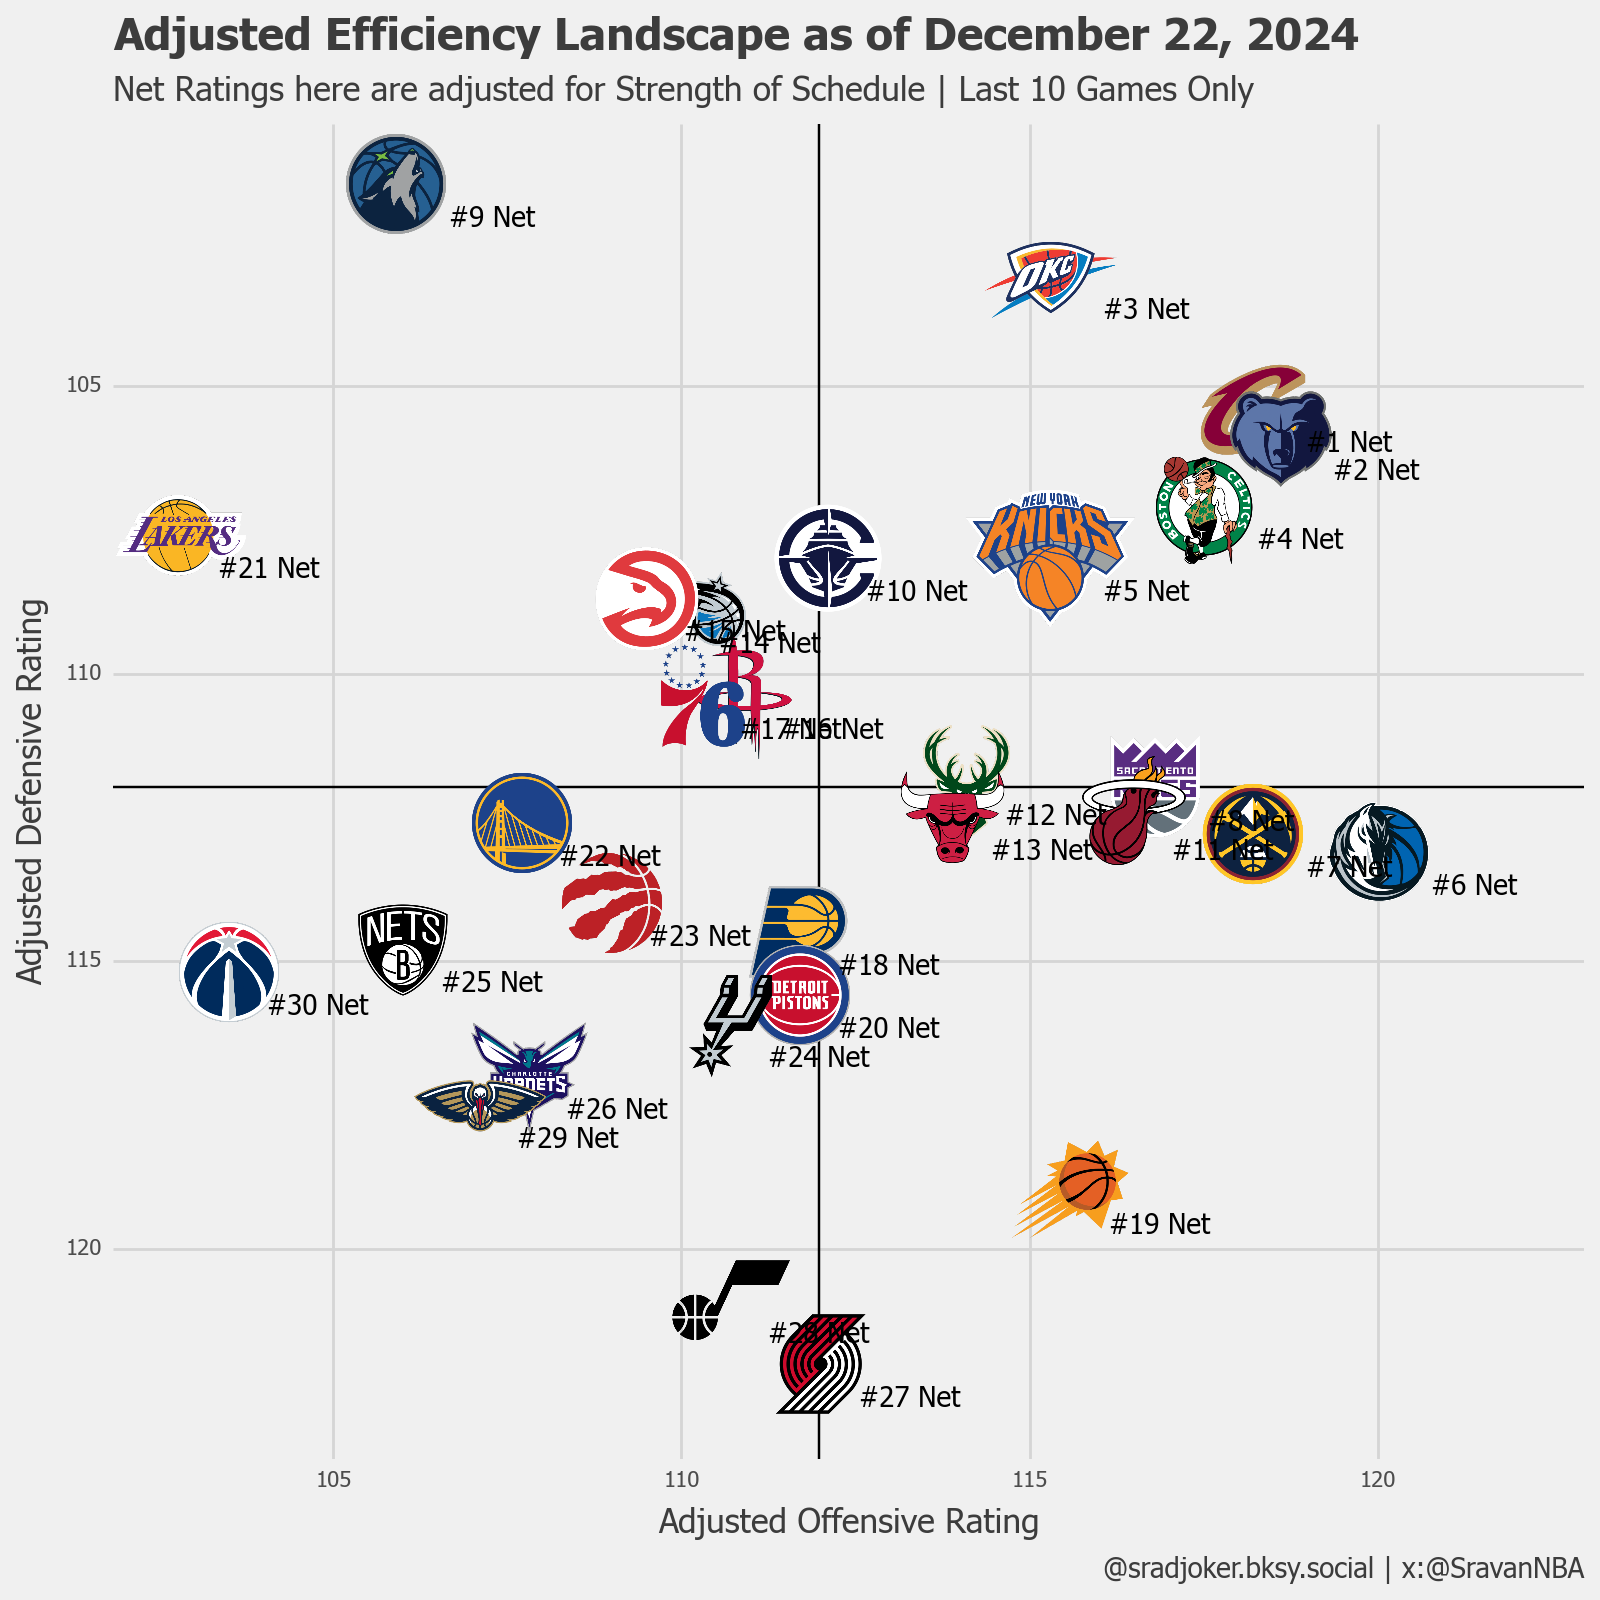

<Figure Size: (800 x 800)>

In [56]:
p = (
    ggplot(data)
    + aes(x="aOFF",y="aDEF",image="image",label="label")
    + geom_hline(yintercept = data["aDEF"].mean(), color = "black")
    + geom_vline(xintercept = data["aOFF"].mean(), color = "black")
    + geom_image(size=0.12)
    # + geom_text(nudge_x = 1.3, nudge_y = 0, size = 6,check_overlap = True)
    + geom_text(nudge_x=2,nudge_y=-0.6, ha='right', size=10)
    + scale_y_reverse()
    + theme_sra
    + theme(
        figure_size=(8,8)
    )
    + labs(
        title = f"Adjusted Efficiency Landscape as of {today}",
        x = "Adjusted Offensive Rating",
        y = "Adjusted Defensive Rating",
        subtitle = "Net Ratings here are adjusted for Strength of Schedule | Last 10 Games Only",
        # subtitle = "Net Ratings here are adjusted for Strength of Schedule",
        # caption = "@SravanNBA"
        caption = "@sradjoker.bsky.social | x:@SravanNBA"
  )
)
p